In [1]:
import numpy as np
import torch
import cv2
import os
from torch import nn, optim
from torchvision import transforms
from torch.utils.data import Dataset
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau
from PIL import Image
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.models import resnet50

In [2]:
DataPath = "flower_images"
dic = {'Lilly': 0, 'Lotus': 1, 'Orchid': 2, 'Sunflower': 3, 'Tulip': 4}

image_path = []
image_labels = []

for name, label in dic.items():
  path = os.path.join(DataPath, name)
  for f in os.listdir(path):
    image_path.append(os.path.join(name, f))
    image_labels.append(label)

In [3]:
class FlowersDataset(Dataset):
    def __init__(self, file_list, file_label, dir, transform=None):
        self.file_list = file_list
        self.file_label = file_label
        self.dir = dir
        self.transform = transform
            
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, idx):
        # Считываем изображение
        image = cv2.imread(os.path.join(self.dir, self.file_list[idx]))
        # Делаем изображение RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # Присваиваем лейбл каждой картинке
        label = self.file_label[idx]
        
        # Преобразуем изображение в PIL формат для дальнейших аугментаций
        image = Image.fromarray(image)
        
        if self.transform:
            image = self.transform(image)
        
        return image, float(label)

class AugmentedFlowersDataset(Dataset):
    def __init__(self, base_dataset, augment_transform, num_augmentations=1):
        self.base_dataset = base_dataset
        self.augment_transform = augment_transform
        self.num_augmentations = num_augmentations

    def __len__(self):
        return len(self.base_dataset) * (self.num_augmentations + 1)

    def __getitem__(self, idx):
        base_len = len(self.base_dataset)
        if idx < base_len:
            return self.base_dataset[idx]
        else:
            original_idx = idx % base_len
            image, label = self.base_dataset[original_idx]
            # Преобразуем тензор обратно в PIL Image для аугментаций
            image = transforms.ToPILImage()(image)
            augmented_image = self.augment_transform(image)
            return augmented_image, label

In [4]:
# Преобразования для тестового датасета
test_transform = transforms.Compose([
    transforms.Resize((100, 100)),
    transforms.ToTensor(),
])

# Аугментации и преобразования для обучающего датасета
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomResizedCrop(100, scale=(0.8, 1.0)),
    transforms.ToTensor(),
])

# Инициализация полного датасета без преобразований
full_dataset = FlowersDataset(image_path, image_labels, DataPath)

# Разделение на обучающую и тестовую выборки
train_size = int(len(full_dataset) * 0.8)
test_size = len(full_dataset) - train_size
train_set, test_set = random_split(full_dataset, [train_size, test_size])

# Применение базовых преобразований к тестовому датасету
test_set.dataset.transform = test_transform

# Создание увеличенного обучающего датасета за счет аугментаций
augmented_train_set = AugmentedFlowersDataset(train_set, train_transform, num_augmentations=2)

# Создание DataLoader'ов
trainloader = DataLoader(augmented_train_set, batch_size=128, shuffle=True, num_workers=0, pin_memory=True)
testloader = DataLoader(test_set, batch_size=128, shuffle=False, num_workers=0)

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
criterion = nn.CrossEntropyLoss()
epoch = 10

In [6]:
def train(model, dataloader, criterion, optimizer, scheduler, epochs, device):
    model.to(device)
    model.train()
    train_losses = []
    train_accuracy = []

    for epoch in range(epochs):
        epoch_loss = 0
        correct = 0
        total = 0

        for _, (data, target) in tqdm(enumerate(dataloader), total=len(dataloader), desc=f"Epoch {epoch+1}/{epochs}"):
            data = data.to(device)
            target = target.to(device).long()

            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

            # Подсчет точности
            _, predicted = torch.max(output, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

        epoch_loss /= len(dataloader)
        train_losses.append(epoch_loss)
        accuracy = 100 * correct / total
        train_accuracy.append(accuracy)

        # Обновление scheduler на основе метрики
        scheduler.step(epoch_loss)

        print(f"Epoch {epoch+1}, Train Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.2f}%")

    return train_losses, train_accuracy

def validate(model, testloader, device):
    total = 0
    correct = 0
    all_labels = []
    all_predictions = []

    # Зададим параметры, чтобы модель не считала градиенты
    with torch.no_grad():
        # переводим модель в режим "оценивания"
        model.eval()
        for images, labels in testloader:
            # прогоняем изображения через модель
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            # получим максимальное значение (это и будет наш лейбл)
            predicted = torch.max(outputs.data, 1)[1]
            # Посчитаем количество лейблов
            total += len(labels)
            # Посчитаем количество правильных предиктов
            correct += (predicted == labels).sum()

            # Сохраним все лейблы и предсказания для дальнейшего анализа
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    accuracy = 100 * correct / float(total)
    print('Accuracy: {:.2f} %'.format(accuracy))

    # Преобразуем списки в numpy массивы для удобства
    all_labels = np.array(all_labels)
    all_predictions = np.array(all_predictions)

    # Получим уникальные классы
    classes = np.unique(np.concatenate((all_labels, all_predictions)))
    num_classes = len(classes)
    class_to_index = {cls: idx for idx, cls in enumerate(classes)}

    # Инициализируем матрицу ошибок
    conf_matrix = np.zeros((num_classes, num_classes), dtype=int)

    # Заполним матрицу ошибок
    for t, p in zip(all_labels, all_predictions):
        conf_matrix[class_to_index[t], class_to_index[p]] += 1

    # Нормализуем матрицу ошибок
    conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

    # Вычислим precision и recall для каждого класса
    precision_per_class = []
    recall_per_class = []

    for i in range(num_classes):
        tp = conf_matrix[i, i]
        fp = conf_matrix[:, i].sum() - tp
        fn = conf_matrix[i, :].sum() - tp
        
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        
        precision_per_class.append(precision)
        recall_per_class.append(recall)

    # Усредненные precision и recall
    precision = np.mean(precision_per_class)
    recall = np.mean(recall_per_class)

    np.set_printoptions(precision=2)

    print('Precision: {:.2f}'.format(precision))
    print('Recall: {:.2f}'.format(recall))
    print('Confusion Matrix (Normalized):')
    print(conf_matrix_normalized)

def plot_data(loss, accuracy):
    epochs = range(1, len(loss) + 1)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, 'b', label='Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, 'r', label='Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [7]:
class ImprovedCNN(nn.Module):
    def __init__(self):
        super(ImprovedCNN, self).__init__()
        
        # Загрузка предобученной модели ResNet50
        self.resnet = resnet50(pretrained=True)
        
        # Замена последнего слоя ResNet
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Identity()  # Убираем последний fully connected слой
        
        # Новые fully connected слои для классификации
        self.fc1 = nn.Linear(num_ftrs, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 5)  # 5 классов
        
        self.dropout = nn.Dropout(p=0.5)
        self.relu = nn.ReLU()

    def forward(self, x):
        # Используем ResNet для извлечения признаков
        x = self.resnet(x)
        
        # Новые fully connected слои
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.fc3(x)
        return x

    def save_model(self, path):
        torch.save(self.state_dict(), path)
        print(f'Model saved to {path}')

    def load_model(self, path):
        self.load_state_dict(torch.load(path))
        self.eval()  # перевести модель в режим оценки
        print(f'Model loaded from {path}')

# Пример использования модели
model = ImprovedCNN()
print(model)

ImprovedCNN(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
       

c:\Users\ilyas\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ilyas\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
improvedCNNModel = ImprovedCNN()
optimizer = optim.Adam(improvedCNNModel.parameters())
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.1, min_lr=1e-6)
(loss, accuracy) = train(improvedCNNModel, trainloader, criterion, optimizer, scheduler, 10, device)
improvedCNNModel.save_model('improvedCNNModel.pt')
improvedCNNModel.load_model('improvedCNNModel.pt')

Epoch 1/10: 100%|██████████| 94/94 [03:29<00:00,  2.23s/it]


Epoch 1, Train Loss: 0.6814, Accuracy: 77.81%


Epoch 2/10: 100%|██████████| 94/94 [03:25<00:00,  2.19s/it]


Epoch 2, Train Loss: 0.4163, Accuracy: 86.72%


Epoch 3/10: 100%|██████████| 94/94 [03:28<00:00,  2.22s/it]


Epoch 3, Train Loss: 0.3162, Accuracy: 89.80%


Epoch 4/10: 100%|██████████| 94/94 [03:28<00:00,  2.21s/it]


Epoch 4, Train Loss: 0.2623, Accuracy: 91.82%


Epoch 5/10: 100%|██████████| 94/94 [03:27<00:00,  2.20s/it]


Epoch 5, Train Loss: 0.2355, Accuracy: 92.53%


Epoch 6/10: 100%|██████████| 94/94 [03:27<00:00,  2.21s/it]


Epoch 6, Train Loss: 0.1917, Accuracy: 93.73%


Epoch 7/10: 100%|██████████| 94/94 [03:27<00:00,  2.21s/it]


Epoch 7, Train Loss: 0.1704, Accuracy: 94.71%


Epoch 8/10: 100%|██████████| 94/94 [03:27<00:00,  2.21s/it]


Epoch 8, Train Loss: 0.1607, Accuracy: 95.01%


Epoch 9/10: 100%|██████████| 94/94 [03:30<00:00,  2.24s/it]


Epoch 9, Train Loss: 0.1604, Accuracy: 94.92%


Epoch 10/10: 100%|██████████| 94/94 [03:27<00:00,  2.20s/it]

Epoch 10, Train Loss: 0.1084, Accuracy: 96.70%
Model saved to improvedCNNModel.pt
Model loaded from improvedCNNModel.pt


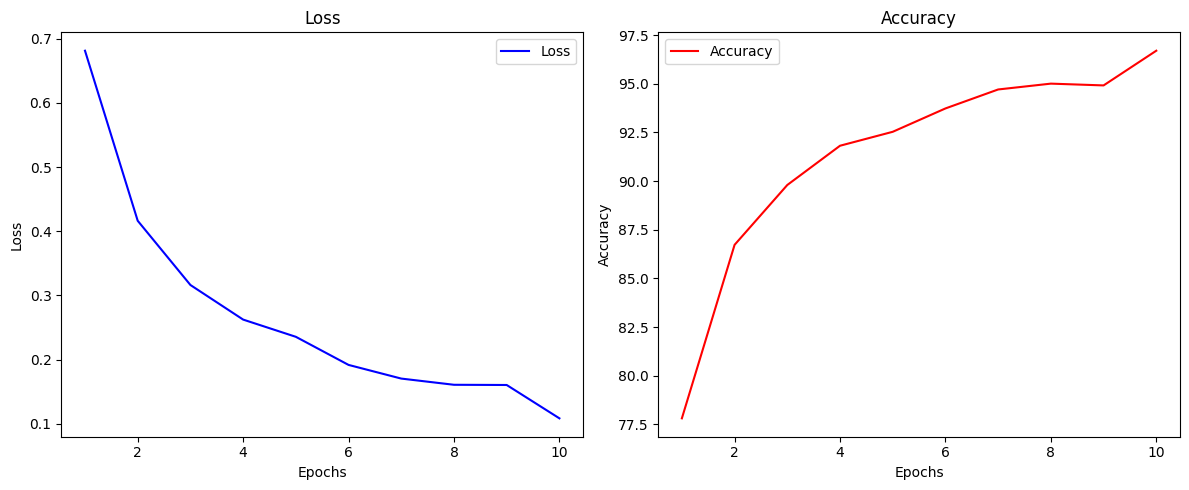

In [9]:
plot_data(loss, accuracy)

In [10]:
validate(improvedCNNModel, testloader, device)

Accuracy: 96.40 %
Precision: 0.96
Recall: 0.96
Confusion Matrix (Normalized):
[[0.95 0.04 0.01 0.   0.  ]
 [0.01 0.96 0.01 0.   0.02]
 [0.03 0.   0.97 0.   0.  ]
 [0.   0.   0.   0.99 0.  ]
 [0.01 0.   0.03 0.   0.95]]
